In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using TensorFlow backend.


In [2]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.3

In [3]:
# reading data
DATA_FILE = 'C:/Users/khmar/git_repo/IssueModelTraining/DATA/DATA.csv'
df = pd.read_csv(DATA_FILE,delimiter=';',encoding='UTF-8')
print(df.head())
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['label'])))

                                                text     label
0  I had ordered a data cable, got a very well fi...  NOTISSUE
1                                   Love This Phone.  NOTISSUE
2                I get a very well finished product.  NOTISSUE
3                            I could not be happier.  NOTISSUE
4  I was looking for this headset for a long time...  NOTISSUE
Shape of dataset  (4064, 2)
Index(['text', 'label'], dtype='object')
No. of unique classes 3


In [4]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [5]:
macronum=sorted(set(df['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [6]:
def fun(i):
    return macro_to_id[i]

df['label']=df['label'].apply(fun)

In [7]:
for i in range(df.text.shape[0]):
    text = BeautifulSoup(df.text[i])
    text=str(text.get_text().encode()).lower()
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in df['label']:
    labels.append(i)

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1


In [18]:
import pickle
file_tok = 'HAN_token_glove_200d_DATA_without_text_processing.sav'
pickle.dump(tokenizer, open(file_tok, 'wb'))

In [9]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 5561 unique tokens.


In [10]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Shape of data tensor: (4064, 15, 100)
Shape of label tensor: (4064, 3)


In [11]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [14]:
embeddings_index = {}
f = open('C:/Users/khmar/Desktop/GLOVE/glove.6B.200d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [15]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)

In [16]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(len(macronum), activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Hierachical LSTM")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           1353200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 1,594,603
Trainable params: 1,594,603
Non-trainable params: 0
_________________________________________________________________


In [17]:
cp=ModelCheckpoint('HAN_model_glove_200_DATA_without_text_processing.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=2,callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Train on 2845 samples, validate on 1219 samples
Epoch 1/2
2845/2845 [==============================] - 561s 197ms/step - loss: 0.5699 - acc: 0.7005 - val_loss: 0.5464 - val_acc: 0.8080

Epoch 00001: val_acc improved from -inf to 0.80804, saving model to HAN_model_glove_200_DATA_without_text_processing.hdf5
Epoch 2/2
2845/2845 [==============================] - 562s 198ms/step - loss: 0.3805 - acc: 0.8439 - val_loss: 0.5523 - val_acc: 0.8146

Epoch 00002: val_acc improved from 0.80804 to 0.81460, saving model to HAN_model_glove_200_DATA_without_text_processing.hdf5


In [19]:
scores= model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

acc: 81.46%


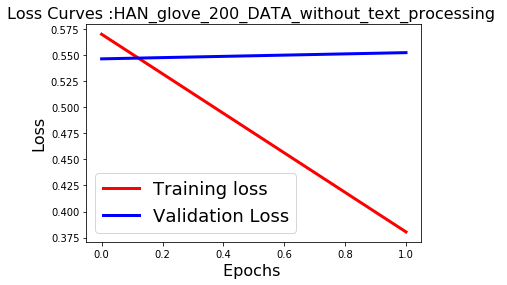

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN_glove_200_DATA_without_text_processing ',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

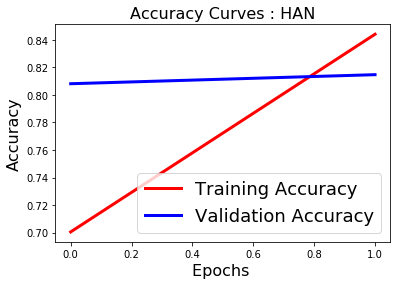

In [21]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_glove_200_DATA_without_text_processing.png')
plt.show()

In [23]:
# Save the model
model.save('HAN_model_glove_200_DATA_without_text_processing.sav')